# How to Build a Model 

In [141]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from src.models.game import NCAAModel
from src.utils import load_target_sample
pd.options.display.float_format = '{:.2f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## NCAA Model Class

Simply use the `NCAAModel` class that automaticall loads the properly indexed data and has cross-validation Routines preimplemented. 
* Below we will use an XGBClassifier estimator to fit the data. Any classifier that implements the classic sklearn-style `fit()` and `predict_proba()` functions will do. 
* A standard feature pipeline is set for the Model and will be loaded in `__init__` unless you provide `preload=False`.

In [2]:
from xgboost import XGBClassifier

m = NCAAModel(Estimator=XGBClassifier)
m

Running Feature Pipeline
-- Seeds --
(2117, 9)
-- Game Features --
(2117, 35)
-- Game Detailed Features --
(2117, 217)
Feature Pipeline Clock: 27 Seconds
Fit Features Loaded: (2117, 211)
Running Feature Pipeline
-- Seeds --
(2278, 9)
-- Game Features --
(2278, 35)
-- Game Detailed Features --
(2278, 217)
Feature Pipeline Clock: 27 Seconds
Pred Features Loaded: (2278, 211)


### Cross Validation
* Cross validation methods are already impletemented on the model.

In [3]:
m.cross_validate(n_splits=5)

,log_loss,ncaa_log_loss
mean,0.24,0.24
std,0.02,0.02
min,0.22,0.22
max,0.26,0.26


* You can also 'sample' from the cross validation error by running random splits repetitively and look at the results

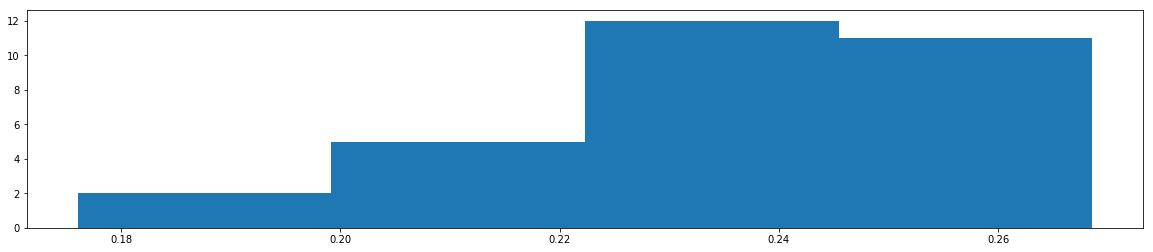

,log_loss,ncaa_log_loss
mean,0.23,0.23
std,0.02,0.02
min,0.18,0.18
max,0.27,0.27


In [4]:
m.cross_validate(n=25, n_splits=10, show_histogram=True)

#### Estimator Parameters

To set the parameters of the estimator for cross-validation (`cross_validate`) or fitting (`fit`, `fit_predict`), simply pass them in form of a `dict` through the `ep` parameter.

In [5]:
m.cross_validate(n=10, n_splits=10, ep={'max_depth': 7, 'subsample': .95, 'n_estimators': 50})

,log_loss,ncaa_log_loss,ep_max_depth,ep_subsample,ep_n_estimators
mean,0.24,0.24,7.00,0.95,50.00
std,0.03,0.03,0.00,0.00,0.00
min,0.18,0.18,7.00,0.95,50.00
max,0.29,0.29,7.00,0.95,50.00


In [6]:
m.cross_validate(n=10, n_splits=10, ep={'max_depth': 1, 'subsample': .75, 'n_estimators': 250})

,log_loss,ncaa_log_loss,ep_max_depth,ep_subsample,ep_n_estimators
mean,0.25,0.25,1.00,0.75,250.00
std,0.02,0.02,0.00,0.00,0.00
min,0.21,0.21,1.00,0.75,250.00
max,0.28,0.28,1.00,0.75,250.00


#### CV History

After fitting the model with different parameters, the history of the cross-validation performance is automatically stored. You can view it through `get_cv_history`. Each cross-validation split is represented as one row. Note that the rows with `nan` are where the estimator was fit with default parameters.

In [7]:
m.get_cv_history().sample(5)

,ep_max_depth,ep_n_estimators,ep_subsample,log_loss,ncaa_log_loss
timestamp,,,,,
2018-03-13 21:34:11.615714,nan,nan,nan,0.25,0.25
2018-03-13 21:34:42.371752,1.00,250.00,0.75,0.28,0.28
2018-03-13 21:34:11.615714,nan,nan,nan,0.26,0.26
2018-03-13 21:34:29.048430,7.00,50.00,0.95,0.23,0.23
2018-03-13 21:34:11.615714,nan,nan,nan,0.18,0.18


In [8]:
m.get_cv_history().fillna('default').groupby(['ep_max_depth', 'ep_n_estimators', 'ep_subsample']).mean()

,,,log_loss,ncaa_log_loss
ep_max_depth,ep_n_estimators,ep_subsample,,
1.0,250.0,0.75,0.25,0.25
7.0,50.0,0.95,0.24,0.24
default,default,default,0.24,0.24


### Custom Features

The default feature pipeline can be overwritten by either adding a `feature_pipeline` function in a subclass of by passing a `feature_pipeline` arguement to the constructor as below.
* A feature_pipeline function takes a data template with `team_a`, `team_b`, `Season`, `DayNum` and target information (e.g. `a_win`)
* The pipeline merges other features onto that template and then returns the teamplate

In [142]:
from datetime import datetime as dt
from src.features import SeedFeatures, GameFeatures, GameDetailedFeatures, EventFeatures


def feature_pipeline(data):
    print('Running Feature Pipeline')
    start = dt.now()
    '''
    print('-- Seeds --')
    seed_feat = SeedFeatures()
    data = seed_feat.per_team_wrapper(
        data, seed_feat.team_seeds,
        per_game=False, per_day=False)
    print(data.shape)
    '''
    print('-- Game Features --')
    game_feat = GameFeatures()
    data = game_feat.per_team_wrapper(
        data, game_feat.last_games_won_in_season)
    data = game_feat.per_team_wrapper(
        data, game_feat.last_games_won_in_tourney)
    data = game_feat.per_team_wrapper(
        data, game_feat.last_games_won_against_opponent,
        per_game=True)
    data = game_feat.per_team_wrapper(
        data, game_feat.games_won_in_tourney_against_opponent,
        per_game=True)
    data.fillna(0, inplace=True)
    print(data.shape)
    '''
    print('-- Game Detailed Features --')
    game_detail_feat = GameDetailedFeatures(default_lags=7)
    data = game_detail_feat.per_team_wrapper(
        data, game_detail_feat.detail_features_by_game,
        per_day=True)
    data.fillna(0, inplace=True)
    print(data.shape)
    print('-- Event Features --')
    event_features = EventFeatures(default_lags=1, rows=100000)
    data = event_features.per_team_wrapper(data, event_features.average_events_in_season)
    data = event_features.per_team_wrapper(data, event_features.total_events_in_season)
    data = event_features.per_team_wrapper(data, event_features.average_events_by_game, per_game=True)
    data = event_features.per_team_wrapper(data, event_features.total_events_by_game, per_game=True)
    data.fillna(0, inplace=True)
    print(data.shape)
    '''
    return data



In [143]:
from src.models.nn.ann import ANN 

In [189]:
m = NCAAModel(feature_pipeline=feature_pipeline, Estimator=ANN)

Running Feature Pipeline
-- Game Features --
(2117, 33)
Fit Features Loaded: (2117, 27)
Running Feature Pipeline
-- Game Features --
(2278, 33)
Pred Features Loaded: (2278, 27)


In [206]:
param_dict = {
    'input_dim': 27,
    'batch_size': 50,
    'hidden_units': [32],
    'eta': 0.01,
    'num_epochs': 10,
    'dropout': 0.2,
}
print(param_dict)


{'input_dim': 27, 'batch_size': 50, 'hidden_units': [32], 'eta': 0.01, 'num_epochs': 10, 'dropout': 0.2}


In [207]:
m.cross_validate(ep=param_dict)

[0.09270663 0.7561458  0.6913801  0.01110987 0.01300859]
[0.7331328  0.57353604 0.978304   0.48991323 0.23028295]
INFO:tensorflow:Restoring parameters from src/saved_models/model.ckpt
[0.01444548 0.90061295 0.5        0.09629263 0.9767412 ]
[8.35170213e-04 8.86263132e-01 9.85222757e-01 1.23716086e-01
 5.16427219e-01]
INFO:tensorflow:Restoring parameters from src/saved_models/model.ckpt
[5.9955385e-02 5.0000000e-01 5.9668773e-01 5.0000000e-01 4.4726810e-04]
[0.00150108 0.73690915 0.89328164 0.04259644 0.05971304]
INFO:tensorflow:Restoring parameters from src/saved_models/model.ckpt


,log_loss,ncaa_log_loss,ep_input_dim,ep_batch_size,ep_hidden_units_0,ep_eta,ep_num_epochs,ep_dropout
mean,0.42,0.42,27.00,50.00,32.00,0.01,10.00,0.20
std,0.04,0.04,0.00,0.00,0.00,0.00,0.00,0.00
min,0.38,0.38,27.00,50.00,32.00,0.01,10.00,0.20
max,0.46,0.46,27.00,50.00,32.00,0.01,10.00,0.20


In [199]:
m.fit_predict(ep=param_dict)

[0.8700253  0.6957114  0.07904198 0.02801247 0.99944204]
[0.9023092  0.72524214 0.5432554  0.09400171 0.9977254 ]
[0.80894697 0.6432271  0.34633827 0.04831368 0.97976995]
[0.75269294 0.6391885  0.39583096 0.09352168 0.97431755]
[0.7838816  0.5        0.47174382 0.10138721 0.98000026]
[0.80425113 0.63829875 0.4550172  0.05908019 0.97189474]
[0.5        0.59198713 0.28765845 0.03347847 0.5       ]
[0.73755485 0.5        0.5        0.0340411  0.5       ]
[0.7784684  0.5        0.5        0.06755701 0.97516453]
[0.757032   0.5        0.33678705 0.03871404 0.5       ]
[0.8068728  0.6560104  0.40324572 0.0615887  0.96954465]
[0.7452869  0.59003973 0.5        0.04122405 0.5       ]
[0.82619286 0.66105455 0.4839629  0.07859925 0.9683925 ]
[0.5        0.619928   0.42416176 0.05286848 0.9664633 ]
[0.8149882  0.66617364 0.343159   0.06807786 0.97025204]
[0.5        0.6088272  0.40488687 0.04394244 0.962571  ]
[0.78388005 0.58331776 0.3172468  0.03962462 0.5       ]
[0.73380345 0.55197364 0.314241

KeyboardInterrupt: 

In [185]:
name_1 = 'Houston'
name_2 = 'San Diego St'
team_ids = pd.read_csv('data/Teams.csv')
#print(team_ids.head())
id_1 = team_ids.loc[[name_1 in team for team in team_ids['TeamName']], ['TeamID', 'TeamName']]
id_2 = team_ids.loc[[name_2 in team for team in team_ids['TeamName']], ['TeamID', 'TeamName']]
print(id_1)
print(id_2)
id_1 = id_1.iloc[0]
id_2 = id_2.iloc[0]

     TeamID        TeamName
121    1222         Houston
122    1223     Houston Bap
257    1358  Sam Houston St
     TeamID      TeamName
260    1361  San Diego St


In [186]:
print(m.pred_targets.loc[(m.pred_targets['team_a'] == str(id_1.values[0])) & (m.pred_targets['team_b'] == str(id_2.values[0]))])
print(m.pred_targets.loc[(m.pred_targets['team_b'] == str(id_1.values[0])) & (m.pred_targets['team_a'] == str(id_2.values[0]))])

               team_a team_b  Season  DayNum  a_win  game_set  b_win
ID                                                                  
2018_1222_1361   1222   1361    2018     366   0.58         0   0.42
Empty DataFrame
Columns: [team_a, team_b, Season, DayNum, a_win, game_set, b_win]
Index: []


In [187]:
team_ids

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018
5,1106,Alabama St,1985,2018
6,1107,Albany NY,2000,2018
7,1108,Alcorn St,1985,2018
8,1109,Alliant Intl,1985,1991
9,1110,American Univ,1985,2018


### Now All at Once

We can build a model that only looks at the detailed data using a `RandomForestClassifier` from `sklearn`.

**Note: This should work on it's own, just don't forget the `imports`**

In [42]:
from datetime import datetime as dt
from src.features import GameDetailedFeatures
from sklearn.ensemble import RandomForestClassifier


def feature_pipeline(data):
    print('Running Feature Pipeline')
    start = dt.now()

    print('-- Games Detailed --')
    game_detail_feat = GameDetailedFeatures(default_lags=7)
    data = game_detail_feat.per_team_wrapper(
        data, game_detail_feat.detail_features_by_game,
        per_day=True)
    data.dropna(inplace=True)
    
    print(data.shape)
    
    print('Feature Pipeline Clock: {} Seconds'
      .format((dt.now() - start).seconds))
    return data


m = NCAAModel(feature_pipeline=feature_pipeline, Estimator=RandomForestClassifier)
m.cross_validate(ep={'n_estimators': 100})

Running Feature Pipeline
-- Games Detailed --
(981, 189)
Feature Pipeline Clock: 21 Seconds
Fit Features Loaded: (981, 183)
Running Feature Pipeline
-- Games Detailed --
(2278, 189)
Feature Pipeline Clock: 19 Seconds
Pred Features Loaded: (2278, 183)


,log_loss,ncaa_log_loss,ep_n_estimators
mean,0.28,0.28,100.00
std,0.01,0.01,0.00
min,0.28,0.28,100.00
max,0.29,0.29,100.00
